Intradey Strategy Using GARCH Model 

1. Load 5-min data

In [22]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

daily_df = pd.read_csv('simulated_daily_data.csv')
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df = daily_df.set_index('Date')
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()
daily_df.head()

intraday_5min_df = pd.read_csv('simulated_5min_data.csv')
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])
intraday_5min_df = intraday_5min_df.set_index('datetime')
intraday_5min_df['date'] = intraday_5min_df.index.date
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['date'])
intraday_5min_df.head()


,open,low,high,close,volume,Unnamed: 6,date
datetime,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,2021-09-29


2. Define funtion to fit GARCH model

In [23]:
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()
#daily_df['variance'].plot()
daily_df = daily_df['2020-01-01':]

def predict_volatility(x):
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]

    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df


d:\Python\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\Python\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\Python\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affec

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_ret,variance,predictions
Date,,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,NaN,0.000914,0.001125,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,NaN,-0.030273,0.001127,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,NaN,0.050172,0.001139,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,NaN,0.008915,0.001110,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,NaN,0.000089,0.001106,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520,0.000384,0.000286


3. Calculate prediction premium and generate daily signals

In [24]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']
daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
#daily_df['prediction_premium'].plot()
#daily_df['premium_std'].plot()
daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std']*1.5) else (-1 if (x['prediction_premium']<x['premium_std']*1.5) else np.nan), axis=1)
daily_df['signal_daily'] = daily_df['signal_daily'].shift()
daily_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,NaN,0.000914,0.001125,NaN,NaN,NaN,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,NaN,-0.030273,0.001127,NaN,NaN,NaN,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,NaN,0.050172,0.001139,NaN,NaN,NaN,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,NaN,0.008915,0.001110,NaN,NaN,NaN,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,NaN,0.000089,0.001106,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801,0.000393,0.000334,-0.151792,0.549073,-1.0
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597,0.000385,0.000292,-0.240810,0.546370,-1.0
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520,0.000384,0.000286,-0.256793,0.545350,-1.0


4. Merge with intraday data and form intraday indicator 

In [28]:
from turtle import left


final_df = intraday_5min_df.reset_index()\
.merge(daily_df[['signal_daily']].reset_index(),left_on='date', right_on='Date')\
.set_index('datetime')

final_df =final_df.drop(['date', 'Date'], axis=1)

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'], length=20)
final_df['lband'] = pandas_ta.bbands(close=final_df['close'], length=20).iloc[:,0]
final_df['uband'] = pandas_ta.bbands(close=final_df['close'], length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if(x['rsi']>70)&(x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&(x['close']<x['lband']) 
                                             else np.nan), 
                                             axis=1)

final_df

,open,low,high,close,volume,Unnamed: 6,signal_daily,rsi,lband,uband,signal_intraday
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,-1.0,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,-1.0,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,-1.0,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,-1.0,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,-1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,-1.0,62.861699,6677.365065,6715.855435,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,-1.0,63.165869,6679.544207,6716.559793,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,-1.0,61.954798,6682.379916,6716.534084,NaN


5. Generate the position entry

In [33]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                         else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1)
                                               else np.nan), axis=1)
final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())
final_df['return'] = final_df['close'].pct_change()
final_df['forward_return'] = final_df['return'].shift(-1)
final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[['strategy_return']].sum()

6. Calculate final strategy return

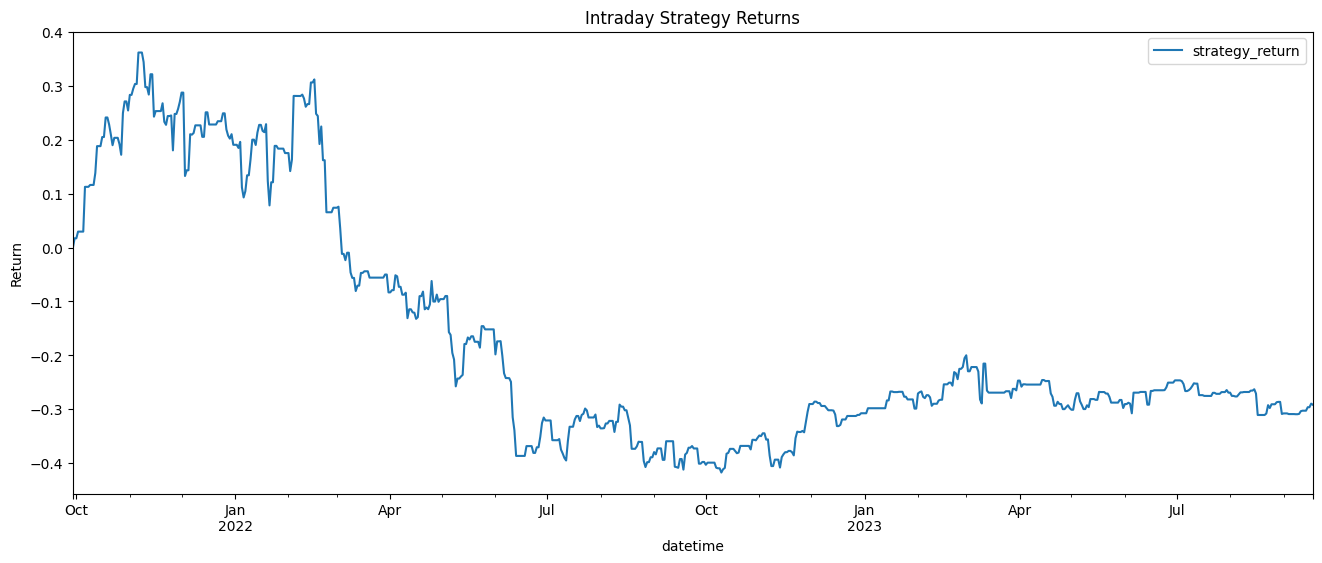

In [37]:
strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))
plt.title('Intraday Strategy Returns')
plt.ylabel('Return')
plt.show()